❓So Why Is the Model Still Missing Overload Cases?
Here’s why:

1. ⏱️ You’re training on chronological sequences, but overloads aren’t always gradual — they can be sudden ZIP bursts
2. 🔁 ZIPs are mixed across chutes over time — but LSTM is seeing one stream
3. 🧠 The model might not be attending to CHUTE_LOAD enough
4. ⚖️ Imbalance is still skewing model toward "no issue"
✅ What You Can Do (Now That You Have CHUTE_LOAD):
✅ 1. Highlight spikes with a chute_load_diff feature
✅ 2. Add ZIP_COUNT_TO_CHUTE (number of ZIPs targeting a chute)


Epoch 01: Loss=0.3954 | MAE=10.75 | Acc=64.46% | Precision=76.01% | Recall=76.08% | F1=76.04%
Epoch 02: Loss=0.3895 | MAE=10.46 | Acc=60.36% | Precision=77.43% | Recall=65.67% | F1=71.07%
Epoch 03: Loss=0.3880 | MAE=10.52 | Acc=54.66% | Precision=81.55% | Recall=50.19% | F1=62.14%
Epoch 04: Loss=0.3878 | MAE=10.40 | Acc=53.69% | Precision=81.35% | Recall=48.69% | F1=60.92%
Epoch 05: Loss=0.3880 | MAE=10.44 | Acc=55.35% | Precision=80.99% | Recall=51.97% | F1=63.31%
Epoch 06: Loss=0.3893 | MAE=10.41 | Acc=45.83% | Precision=84.09% | Recall=33.21% | F1=47.61%
Epoch 07: Loss=0.3871 | MAE=10.42 | Acc=54.38% | Precision=81.35% | Recall=49.91% | F1=61.86%
Epoch 08: Loss=0.3875 | MAE=10.43 | Acc=46.24% | Precision=83.99% | Recall=33.96% | F1=48.36%
Epoch 09: Loss=0.3869 | MAE=10.51 | Acc=47.29% | Precision=84.84% | Recall=35.18% | F1=49.73%
Epoch 10: Loss=0.3859 | MAE=10.42 | Acc=51.18% | Precision=83.21% | Recall=42.78% | F1=56.51%
Epoch 11: Loss=0.3853 | MAE=10.49 | Acc=51.32% | Precision=8

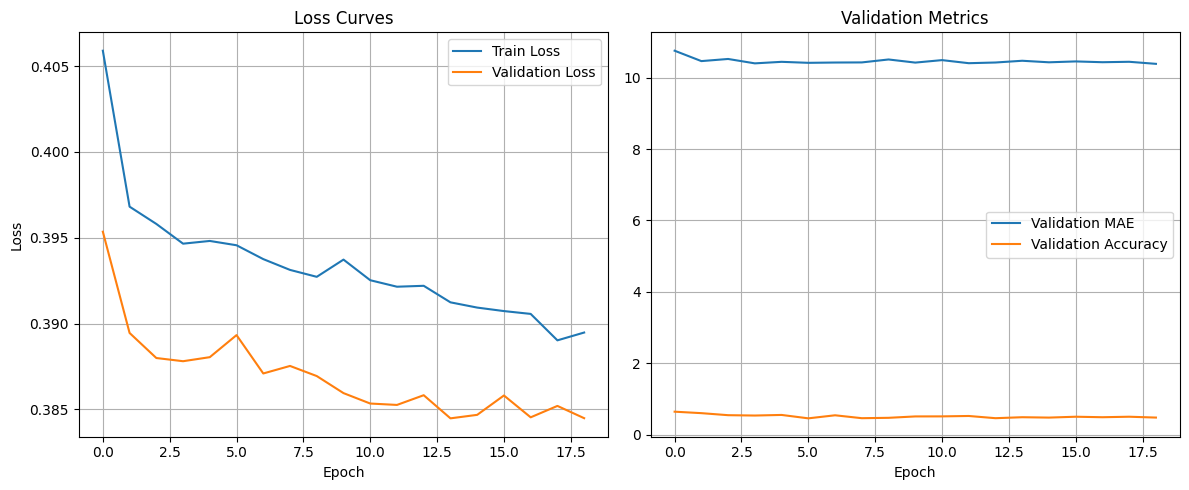

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# 1. Load and prepare data
df = pd.read_csv("../DATA/data10dayR0201.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])

# Encode categorical fields
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# Add feature: number of ZIPs sending to the chute at each hour
df['zip_count_to_chute'] = df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

# Define features and targets
features = [
    'CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
    'CHUTE_LOAD', 'ZIP_PACKAGE_COUNT', 'HOUR_OF_DAY', 'DAY_OF_WEEK',
    'zip_count_to_chute'  # newly added feature
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'PERFORMANCE_ISSUE'

# Normalize features and regression target
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])
target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# Create sequences
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# Create datasets and loaders
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# Define LSTM model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)  # No sigmoid

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.fc_cls(out)

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()

# Weighted loss for class imbalance
issue_counts = df['PERFORMANCE_ISSUE'].value_counts()
pos_weight = torch.tensor([issue_counts[0] / issue_counts[1]])
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses, val_losses = [], []
val_mae_scores, val_acc_scores = [], []
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    train_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls_logits = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls_logits.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    y_reg_preds, y_cls_preds = [], []
    y_reg_true, y_cls_true = [], []

    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls_logits = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls_logits.view(-1), yb_cls)
            val_loss += loss.item()

            y_reg_preds.extend(out_reg.view(-1).numpy())
            y_cls_preds.extend(torch.sigmoid(out_cls_logits.view(-1)).numpy())
            y_reg_true.extend(yb_reg.numpy())
            y_cls_true.extend(yb_cls.numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_mae = mean_absolute_error(
        target_scaler.inverse_transform(np.array(y_reg_true).reshape(-1, 1)),
        target_scaler.inverse_transform(np.array(y_reg_preds).reshape(-1, 1))
    )
    val_acc = accuracy_score(y_cls_true, np.array(y_cls_preds) > 0.5)
    val_precision = precision_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_recall = recall_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_f1 = f1_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)

    val_mae_scores.append(val_mae)
    val_acc_scores.append(val_acc)

    print(f"Epoch {epoch+1:02}: Loss={val_loss:.4f} | MAE={val_mae:.2f} | "
          f"Acc={val_acc:.2%} | Precision={val_precision:.2%} | Recall={val_recall:.2%} | F1={val_f1:.2%}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Save best model
torch.save(best_model_state, "best_lstm_hybridv5_onechout.pt")
print("✅ Best model saved.")

# Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_mae_scores, label="Validation MAE")
plt.plot(val_acc_scores, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.title("Validation Metrics")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [5]:
def predict_and_compare_at_time(df_raw, target_time, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df = df_raw[df_raw['HOUR_TIME'] <= pd.to_datetime(target_time)]
    df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    results = []

    for chute in df['CHUTE'].unique():
        chute_df = df[df['CHUTE'] == chute].copy()
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue

        seq_df = chute_df.iloc[-seq_len:].copy()

        # Encode categorical features as in training
        seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
        seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes

        # Recreate missing engineered feature
        if 'zip_count_to_chute' not in seq_df.columns:
            seq_df['zip_count_to_chute'] = seq_df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

        # Scale features
        seq_df[features] = feature_scaler.transform(seq_df[features])

        # Prepare input tensor
        x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

        with torch.no_grad():
            y_pred_reg, y_pred_cls_logits = model(x_seq)

            # Apply sigmoid manually
            prob = torch.sigmoid(y_pred_cls_logits.view(-1)).item()
            pred_issue = int(prob > 0.5)

            pred_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]

        latest = chute_df.iloc[-1]
        actual_time = latest['AVG_PROCESSING_TIME_MINUTES']
        actual_issue = latest['PERFORMANCE_ISSUE']
        zip_code = latest['ZIP_CODE']
        hour = latest['HOUR_TIME']

        results.append({
            'Time': hour,
            'CHUTE': chute,
            'ZIP_CODE': zip_code,
            'Actual_Processing_Time': actual_time,
            'Predicted_Processing_Time': pred_time,
            'Actual_Performance_Issue': actual_issue,
            'Predicted_Performance_Issue': pred_issue,
            'Predicted_Issue_Probability': prob
        })

    return pd.DataFrame(results)


In [6]:
df = pd.read_csv("../DATA/data10dayR0201.csv")

compare_df = predict_and_compare_at_time(
    df_raw=df,
    target_time="2025-03-17 11:00",  # Pick any timestamp you like
    model=model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_len=5
)

print(compare_df)


                 Time  CHUTE  ZIP_CODE  Actual_Processing_Time  \
0 2025-03-17 11:00:00  R0201    803200                   22.25   

   Predicted_Processing_Time  Actual_Performance_Issue  \
0                  26.772004                         1   

   Predicted_Performance_Issue  Predicted_Issue_Probability  
0                            1                      0.69077  


C:\Users\mansourmoa\AppData\Local\Temp\ipykernel_35432\3053477384.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)


In [7]:
print(df['HOUR_TIME'].min(), df['HOUR_TIME'].max())


2025-03-17 07:00:00 2025-03-26 23:00:00


In [8]:
def scan_and_predict_issues(df_raw, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df_raw = df_raw.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    results = []
    issue_points = df_raw[df_raw['PERFORMANCE_ISSUE'] == 1]

    for idx, row in issue_points.iterrows():
        chute = row['CHUTE']
        time = row['HOUR_TIME']

        chute_df = df_raw[(df_raw['CHUTE'] == chute) & (df_raw['HOUR_TIME'] <= time)]
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue

        seq_df = chute_df.iloc[-seq_len:].copy()

        # Encode categorical features
        seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
        seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes

        # Recreate missing engineered feature
        if 'zip_count_to_chute' not in seq_df.columns:
            seq_df['zip_count_to_chute'] = seq_df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

        # Scale features
        seq_df[features] = feature_scaler.transform(seq_df[features])

        # Prepare input tensor
        x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

        with torch.no_grad():
            y_pred_reg, y_pred_cls_logits = model(x_seq)

            # Apply sigmoid manually to classification output
            prob = torch.sigmoid(y_pred_cls_logits.view(-1)).item()
            pred_issue = int(prob > 0.5)

            pred_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]

        results.append({
            'HOUR_TIME': time,
            'CHUTE': chute,
            'ZIP_CODE': row['ZIP_CODE'],
            'Actual_Processing_Time': row['AVG_PROCESSING_TIME_MINUTES'],
            'Predicted_Processing_Time': pred_time,
            'Actual_Performance_Issue': row['PERFORMANCE_ISSUE'],
            'Predicted_Performance_Issue': pred_issue,
            'Predicted_Issue_Probability': prob
        })

    return pd.DataFrame(results)


In [9]:
df = pd.read_csv("../DATA/data10dayR0201.csv")

issue_preds = scan_and_predict_issues(
    df_raw=df,
    model=model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_len=5
)

print(issue_preds.head())


            HOUR_TIME  CHUTE  ZIP_CODE  Actual_Processing_Time  \
0 2025-03-19 14:00:00  R0201    100027               15.983333   
1 2025-03-17 18:00:00  R0201    100300               25.583333   
2 2025-03-17 19:00:00  R0201    100300               61.216667   
3 2025-03-17 20:00:00  R0201    100300               30.200000   
4 2025-03-19 16:00:00  R0201    100300               27.983333   

   Predicted_Processing_Time  Actual_Performance_Issue  \
0                  18.454836                         1   
1                  24.298279                         1   
2                  28.349997                         1   
3                  28.837825                         1   
4                  19.637942                         1   

   Predicted_Performance_Issue  Predicted_Issue_Probability  
0                            0                     0.450880  
1                            1                     0.540541  
2                            1                     0.740889  
3     

In [10]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

def scan_and_predict_issues(df_raw, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df_raw = df_raw.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    results = []
    issue_points = df_raw[df_raw['PERFORMANCE_ISSUE'] == 1]

    for idx, row in issue_points.iterrows():
        chute = row['CHUTE']
        time = row['HOUR_TIME']

        chute_df = df_raw[(df_raw['CHUTE'] == chute) & (df_raw['HOUR_TIME'] <= time)]
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue

        seq_df = chute_df.iloc[-seq_len:].copy()

        # Encode categorical features
        seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
        seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes

        # Recreate missing engineered feature
        if 'zip_count_to_chute' not in seq_df.columns:
            seq_df['zip_count_to_chute'] = seq_df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

        # Scale features
        seq_df[features] = feature_scaler.transform(seq_df[features])

        # Prepare input tensor
        x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

        with torch.no_grad():
            y_pred_reg, y_pred_cls_logits = model(x_seq)

            # Apply sigmoid manually to classification output
            prob = torch.sigmoid(y_pred_cls_logits.view(-1)).item()
            pred_issue = int(prob > 0.5)

            pred_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]

        results.append({
            'HOUR_TIME': time,
            'CHUTE': chute,
            'ZIP_CODE': row['ZIP_CODE'],
            'Actual_Processing_Time': row['AVG_PROCESSING_TIME_MINUTES'],
            'Predicted_Processing_Time': pred_time,
            'Actual_Performance_Issue': row['PERFORMANCE_ISSUE'],
            'Predicted_Performance_Issue': pred_issue,
            'Predicted_Issue_Probability': prob
        })

    return pd.DataFrame(results)


def plot_issue_predictions(issue_df):
    issue_df = issue_df.sort_values("HOUR_TIME")

    # 🔹 Line Plot Over Time
    plt.figure(figsize=(14, 5))
    plt.plot(issue_df['HOUR_TIME'], issue_df['Actual_Processing_Time'], label='Actual', marker='o')
    plt.plot(issue_df['HOUR_TIME'], issue_df['Predicted_Processing_Time'], label='Predicted', marker='x')
    plt.xlabel("Time")
    plt.ylabel("Processing Time (min)")
    plt.title("🛑 Actual vs Predicted Processing Time at Issue Points")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 🔹 Scatter Plot: Actual vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(issue_df['Actual_Processing_Time'], issue_df['Predicted_Processing_Time'], alpha=0.6)
    max_val = max(issue_df['Actual_Processing_Time'].max(), issue_df['Predicted_Processing_Time'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')
    plt.xlabel("Actual Processing Time (min)")
    plt.ylabel("Predicted Processing Time (min)")
    plt.title("🎯 Prediction Accuracy at Issue Points")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\mansourmoa\AppData\Local\Temp\ipykernel_35432\2099839921.py:76: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\mansourmoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


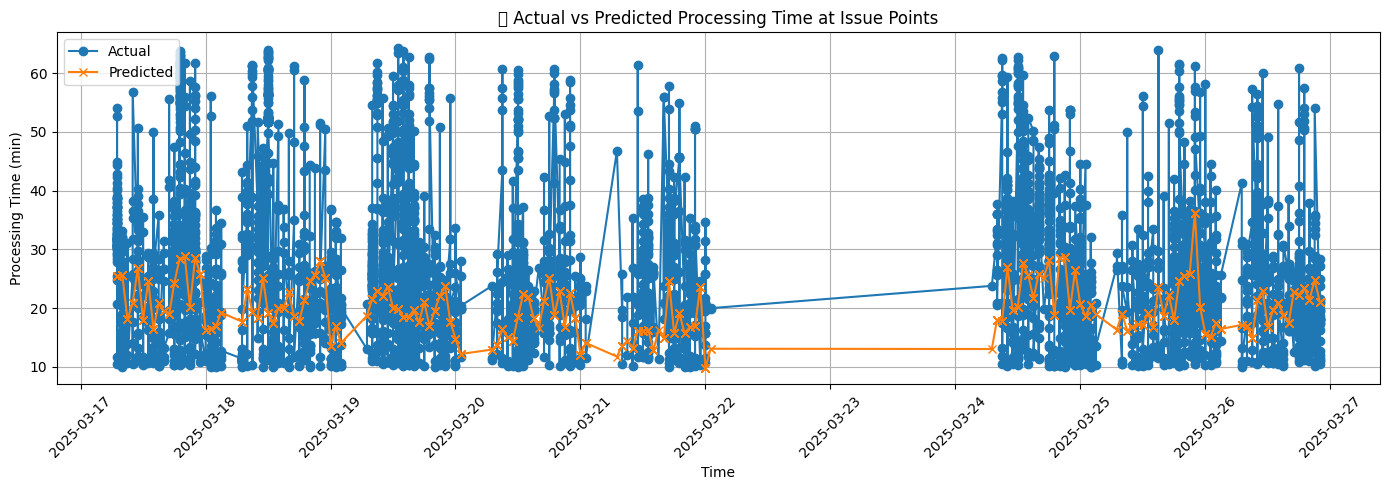

C:\Users\mansourmoa\AppData\Local\Temp\ipykernel_35432\2099839921.py:89: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\mansourmoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


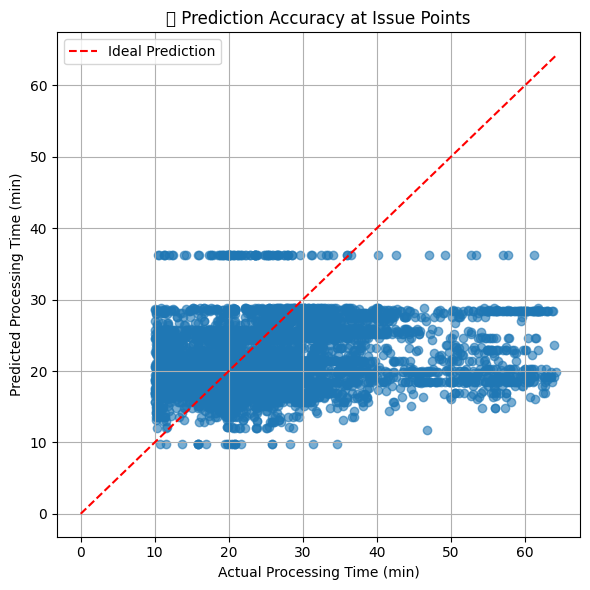

In [11]:
df = pd.read_csv("../DATA/data10dayR0201.csv")

issue_preds = scan_and_predict_issues(df, model, feature_scaler, target_scaler)

plot_issue_predictions(issue_preds)